In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import os

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [18]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

In [23]:
mpl.rcParams.update({'font.size': 8})


In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388

GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [4]:
def get_orbit(Rs, Vv, ecc):
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc+'/output'
    orbit = {}
    orbit['Time'] = []
    orbit['Orbit'] = []
    for idx in np.arange(320+1):
        fname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
        
        if not os.path.exists(fname):
            print('got to idx='+str(idx-1)+' for Rs,Vv,ecc='+Rs+','+Vv+','+ecc)
            break
        
        t = h5.File(fname, mode='r')
        orbit['Time'].append(t['Header'].attrs['Time'])
        SubhaloPos = t['Subhalo/SubhaloPos'][:]
        if len(SubhaloPos) > 1:
            orbit['Orbit'].append(SubhaloPos[1] - SubhaloPos[0])
        else:
            orbit['Orbit'].append(np.array([0., 0., 0.]))
        t.close()
    
    for k in orbit.keys():
        orbit[k] = np.array(orbit[k])
    
    orbit['Rsep'] = np.linalg.norm(orbit['Orbit'], axis=1)
        
    return orbit

In [5]:
Rs = '142'
Vv = '116'
ecc = '04'
idx = 320

In [6]:
orbit = get_orbit(Rs, Vv, ecc)
key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
gal = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

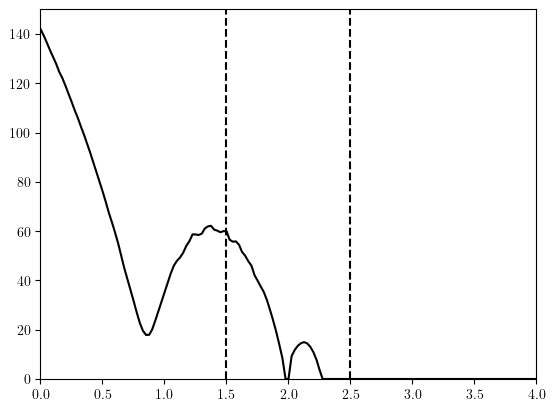

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(orbit['Time'], orbit['Rsep'], c='k')
ax.set(xlim=(0, 4), ylim=(0, 150))

tmerge = [1.5, 2.5]
ax.axvline(tmerge[0], c='k', ls='dashed')
ax.axvline(tmerge[1], c='k', ls='dashed')

In [8]:
logFeH_lim=[-1.1, 0.6]
logMgFe_lim=[0.1, 0.65]
    
sn = gal.sn
    
### get logFeH and logMgFe ###
FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
logFeH = np.log10(FeH)
logMgH = np.log10(MgH)
logMgFe = logMgH - logFeH

### get in_SN ###
Lzsun = 8 * 220
zmax = 3
dLz = 0.1
    
Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
in_SN = np.logical_and((Lz/Lzsun)-1 < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
### get tform ###
tform = sn.part4.GFM_StellarFormationTime
keybool = np.logical_and(in_SN, tform > 0)

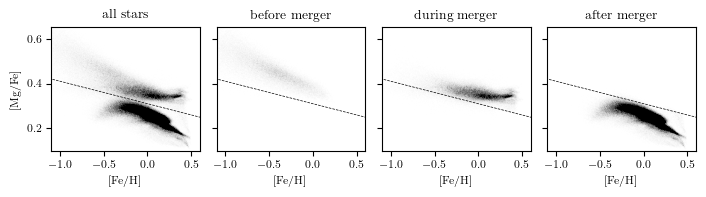

In [59]:
fig, axs = plt.subplots(1, 4, figsize=(textwidth, 0.6*columnwidth), sharex=True, sharey=True)

N_FeH = 200
N_MgFe = 200
FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe

# FeH_points = 0.5*(FeH_bins[1:] + FeH_bins[:-1])
# MgFe_points = 0.5*(MgFe_bins[1:] + MgFe_bins[:-1])
# grid_FeH, grid_MgFe = np.meshgrid(FeH_points, MgFe_points)

tbounds = ((-100, 100), (0, tmerge[0]), (tmerge[0], tmerge[1]), (tmerge[1], 100))

for ax,tbound in zip(axs, tbounds):
    key = np.logical_and(keybool, np.logical_and(tform < tbound[1], tform > tbound[0]))
    
    H, _, _, _ = binned_statistic_2d(logFeH[key], logMgFe[key], 
                                     np.ones(np.sum(key))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im = ax.imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                logMgFe_lim[0], logMgFe_lim[1]],
                    cmap='Greys', vmin=0, vmax=3e6)
    # ax.contour(grid_FeH, grid_MgFe, H.T)
    
    ax.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$')
    ax.set(aspect='auto')
    
    m = -0.15/1.5
    b = 0.31
    xlist = np.linspace(-3, 3, 1000)
    ylist = m*xlist + b
    ax.plot(xlist, ylist, c='k', ls='dashed', lw=0.5)

axs[0].set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')

axs[0].set_title(r'$\textrm{all stars}$')
axs[1].set_title(r'$\textrm{before merger}$')
axs[2].set_title(r'$\textrm{during merger}$')
axs[3].set_title(r'$\textrm{after merger}$')

key = np.logical_and(keybool, tform < tmerge[0])
H, _, _, _ = binned_statistic_2d(logFeH[key], logMgFe[key], 
                                 np.ones(np.sum(key))/dFeH/dMgFe,
                                 statistic='sum', bins=[FeH_bins, MgFe_bins])

fig.tight_layout()
fig.savefig('before_after.pdf')

plt.show()

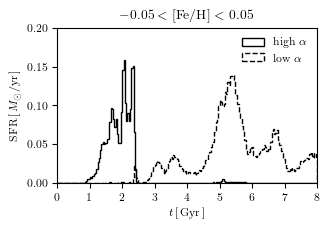

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.6*columnwidth))

yalpha = m*logFeH + b
high_alpha = logMgFe > yalpha
low_alpha = np.logical_not(high_alpha)

in_band = np.logical_and(logFeH > -0.05, logFeH < 0.05)
high_alpha = np.logical_and(high_alpha, in_band)
low_alpha = np.logical_and(low_alpha, in_band)

mass_form = sn.part4.GFM_InitialMass
tbins =np.linspace(0, 8, 200+1)
dt = (tbins[-1] - tbins[0]) / 200

ax.hist(tform[high_alpha], bins=tbins, weights=mass_form[high_alpha]/dt, 
        histtype='step', color='k', label=r'$\textrm{high } \alpha$');

ax.hist(tform[low_alpha], bins=tbins, weights=mass_form[low_alpha]/dt, 
        histtype='step', color='k', ls='dashed', label=r'$\textrm{low } \alpha$')

ax.set(xlim=(0, 8), ylim=(0, 0.2))
ax.set(xticks=np.arange(0, 8+1, 1))
ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$', ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
ax.legend(frameon=False)
ax.set_title(r'$-0.05 < [\textrm{Fe}/\textrm{H}] < 0.05$')
fig.savefig('before_after_sfh.pdf')